In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn joblib


In [ ]:
# --- Bagian 1: Import Library ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

sns.set(style="whitegrid")

# Format tampilan angka agar tidak pakai notasi e+08
pd.options.display.float_format = '{:,.0f}'.format


In [ ]:
# --- Bagian 2: Generate Synthetic Dataset (versi realistis) ---

np.random.seed(42)
n_samples = 250

# Fitur
luas_tanah = np.random.uniform(50, 500, n_samples)
luas_bangunan = np.random.uniform(30, 400, n_samples)
jumlah_kamar = np.random.randint(1, 6, n_samples)
umur_bangunan = np.random.uniform(0, 30, n_samples)
jarak_pusat_kota = np.random.uniform(1, 20, n_samples)

# Rumus realistis harga (dalam juta)
# logika: harga dasar 300 juta + kontribusi fitur + noise
harga_properti_juta = (
    300 +                                 # harga dasar
    1.8 * luas_tanah +                    # pengaruh luas tanah
    2.5 * luas_bangunan +                 # pengaruh luas bangunan
    150 * jumlah_kamar -                  # pengaruh kamar
    10 * umur_bangunan -                  # makin tua makin turun
    20 * jarak_pusat_kota +               # makin jauh makin turun
    np.random.normal(0, 100, n_samples)   # noise kecil
)

# Pastikan harga minimal 200 juta, maksimal 5000 juta (5 M)
harga_properti_juta = np.clip(harga_properti_juta, 200, 5000)

# Konversi ke Rupiah
harga_properti_rp = harga_properti_juta * 1_000_000

# Buat DataFrame
data = pd.DataFrame({
    'Luas_Tanah_(m2)': luas_tanah,
    'Luas_Bangunan_(m2)': luas_bangunan,
    'Jumlah_Kamar': jumlah_kamar,
    'Umur_Bangunan_(tahun)': umur_bangunan,
    'Jarak_Pusat_Kota_(km)': jarak_pusat_kota,
    'Harga_Properti_(Rp)': harga_properti_rp
})

# Lihat range harga
print("Harga minimum:", f"Rp {data['Harga_Properti_(Rp)'].min():,.0f}")
print("Harga maksimum:", f"Rp {data['Harga_Properti_(Rp)'].max():,.0f}")

data.head(10)


Harga minimum: Rp 250,890,021
Harga maksimum: Rp 2,412,855,487


,Luas_Tanah_(m2),Luas_Bangunan_(m2),Jumlah_Kamar,Umur_Bangunan_(tahun),Jarak_Pusat_Kota_(km),Harga_Properti_(Rp)
0,219,139,1,2,14,"889,377,883"
1,478,172,1,10,4,"1,350,147,594"
2,379,345,1,4,18,"1,660,627,932"
3,319,147,5,2,9,"1,902,927,836"
4,120,93,4,30,8,"715,475,824"
5,120,236,5,10,11,"1,501,852,560"
6,76,376,4,24,2,"1,574,194,553"
7,440,288,5,8,4,"2,383,076,331"
8,321,241,5,20,15,"1,789,169,784"
9,369,66,3,23,3,"1,397,626,083"


Statistik Deskriptif:
        Luas_Tanah_(m2)  Luas_Bangunan_(m2)  Jumlah_Kamar  \
count              250                 250           250   
mean               271                 217             3   
std                134                 111             1   
min                 52                  34             1   
25%                154                 133             2   
50%                276                 224             3   
75%                389                 310             4   
max                494                 397             5   

       Umur_Bangunan_(tahun)  Jarak_Pusat_Kota_(km)  Harga_Properti_(Rp)  
count                    250                    250                  250  
mean                      15                     11        1,409,416,387  
std                        9                      6          434,114,076  
min                        0                      1          250,890,021  
25%                        7                      6        1,

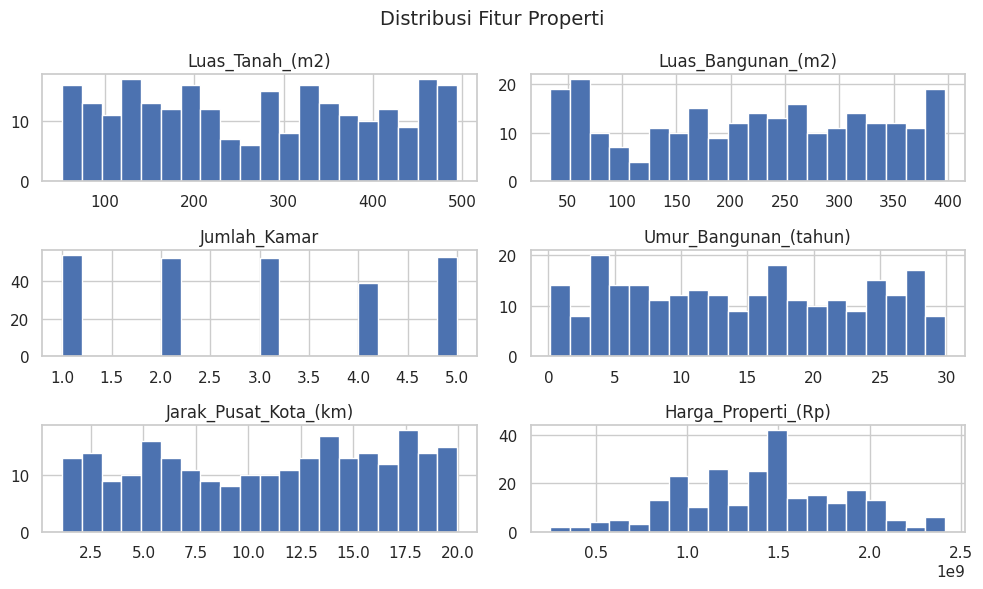

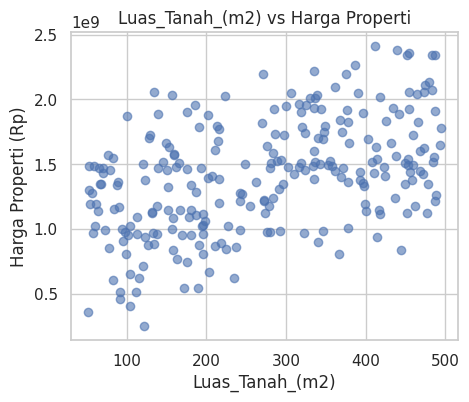

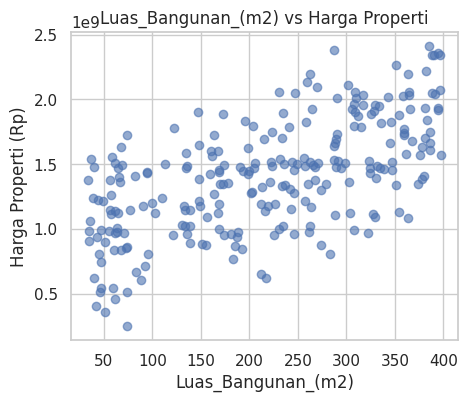

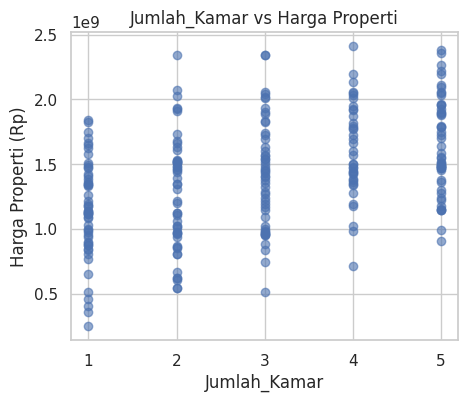

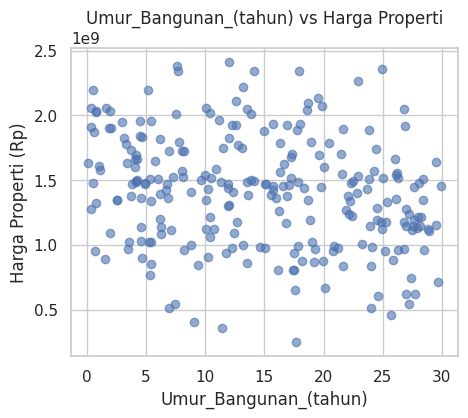

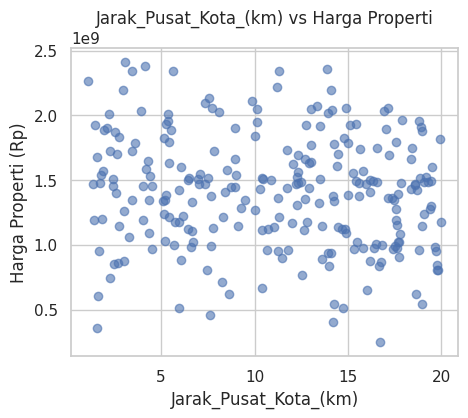

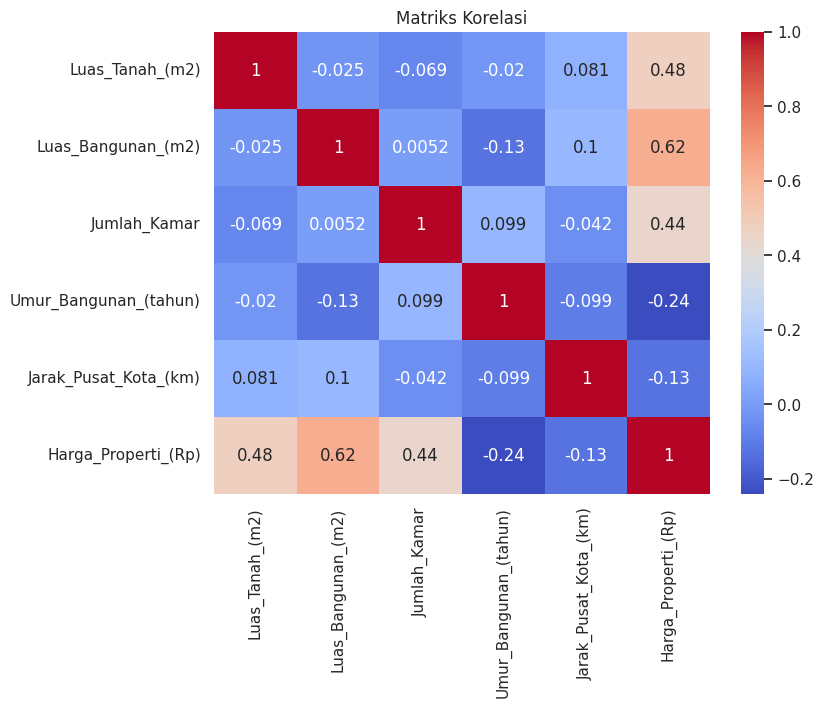

In [ ]:
# --- Bagian 3: EDA ---

print("Statistik Deskriptif:\n", data.describe())

# Distribusi fitur
data.hist(bins=20, figsize=(10, 6))
plt.suptitle("Distribusi Fitur Properti", fontsize=14)
plt.tight_layout()
plt.show()

# Scatter plot fitur vs harga
for col in data.columns[:-1]:
    plt.figure(figsize=(5,4))
    plt.scatter(data[col], data['Harga_Properti_(Rp)'], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel("Harga Properti (Rp)")
    plt.title(f"{col} vs Harga Properti")
    plt.show()

# Korelasi antar fitur
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Matriks Korelasi")
plt.show()


In [ ]:
# --- Bagian 4: Preprocessing ---

X = data.drop(columns=['Harga_Properti_(Rp)'])
y = data['Harga_Properti_(Rp)']

# Split data 70:30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "scaler.pkl")
print("Scaler disimpan sebagai scaler.pkl")


Scaler disimpan sebagai scaler.pkl


In [ ]:
# --- Bagian 5: Polynomial Regression ---

degrees = [1, 2, 3, 4, 5]
results = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = Ridge(alpha=1.0)  # Ridge mengurangi overfitting
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    results.append({
        "Degree": d,
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred))
    })

res_df = pd.DataFrame(results)
res_df


,Degree,Train R2,Test R2,RMSE
0,1,1,1,"111,595,195"
1,2,1,1,"117,823,633"
2,3,1,1,"132,974,815"
3,4,1,1,"180,284,841"
4,5,1,1,"270,739,795"


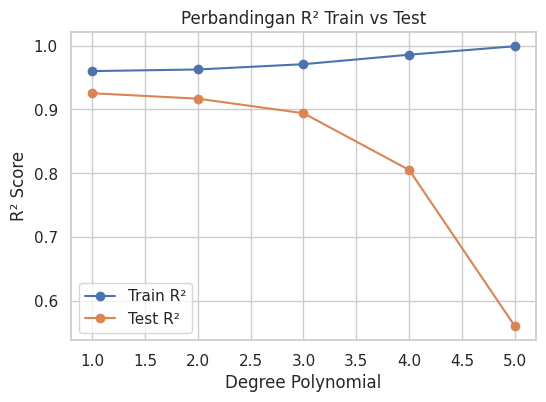

In [ ]:
# --- Bagian 6: Visualisasi R² ---

plt.figure(figsize=(6,4))
plt.plot(res_df["Degree"], res_df["Train R2"], marker='o', label="Train R²")
plt.plot(res_df["Degree"], res_df["Test R2"], marker='o', label="Test R²")
plt.xlabel("Degree Polynomial")
plt.ylabel("R² Score")
plt.legend()
plt.title("Perbandingan R² Train vs Test")
plt.show()


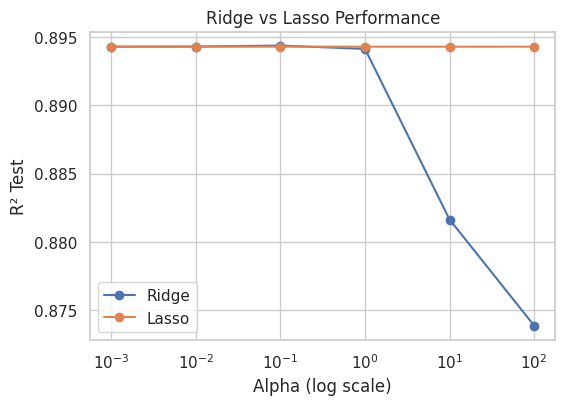

In [ ]:
# --- Bagian 7: Ridge vs Lasso Regularization ---

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_scores, lasso_scores = [], []

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

for a in alphas:
    ridge = Ridge(alpha=a).fit(X_train_poly, y_train)
    lasso = Lasso(alpha=a, max_iter=5000).fit(X_train_poly, y_train)

    ridge_scores.append(ridge.score(X_test_poly, y_test))
    lasso_scores.append(lasso.score(X_test_poly, y_test))

plt.figure(figsize=(6,4))
plt.plot(alphas, ridge_scores, marker='o', label='Ridge')
plt.plot(alphas, lasso_scores, marker='o', label='Lasso')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("R² Test")
plt.legend()
plt.title("Ridge vs Lasso Performance")
plt.show()



In [ ]:
# --- Bagian 8: Model Terbaik ---

best_degree = res_df.loc[res_df['Test R2'].idxmax(), 'Degree']
print(f"Model terbaik berdasarkan R² Test: Degree {best_degree}")

poly_best = PolynomialFeatures(degree=int(best_degree))
X_train_poly = poly_best.fit_transform(X_train_scaled)
model_best = LinearRegression().fit(X_train_poly, y_train)

joblib.dump((poly_best, model_best), "best_model.pkl")
print("Model terbaik disimpan sebagai best_model.pkl")


Model terbaik berdasarkan R² Test: Degree 1
Model terbaik disimpan sebagai best_model.pkl


In [ ]:
# --- Bagian 9: Prediksi Data Baru ---

# Load model dan scaler
scaler = joblib.load("scaler.pkl")
poly_best, model_best = joblib.load("best_model.pkl")

# 5 data baru
data_baru = pd.DataFrame({
    'Luas_Tanah_(m2)': [100, 250, 400, 150, 320],
    'Luas_Bangunan_(m2)': [80, 180, 250, 120, 220],
    'Jumlah_Kamar': [2, 3, 4, 2, 5],
    'Umur_Bangunan_(tahun)': [5, 10, 2, 15, 7],
    'Jarak_Pusat_Kota_(km)': [10, 5, 8, 12, 6]
})

# Prediksi harga
X_new_scaled = scaler.transform(data_baru)
X_new_poly = poly_best.transform(X_new_scaled)
prediksi = model_best.predict(X_new_poly)

# Pastikan positif & format Rupiah
prediksi = np.abs(prediksi)
data_baru['Prediksi_Harga_(Rp)'] = [f"Rp {p:,.0f}" for p in prediksi]

data_baru


,Luas_Tanah_(m2),Luas_Bangunan_(m2),Jumlah_Kamar,Umur_Bangunan_(tahun),Jarak_Pusat_Kota_(km),Prediksi_Harga_(Rp)
0,100,80,2,5,10,"Rp 750,213,753"
1,250,180,3,10,5,"Rp 1,449,397,337"
2,400,250,4,2,8,"Rp 2,053,656,401"
3,150,120,2,15,12,"Rp 801,327,014"
4,320,220,5,7,6,"Rp 1,973,086,629"


In [53]:
# Simpan daftar dependensi yang digunakan
!pip freeze > requirements.txt

In [54]:
%%writefile README.md

# Ujian Tengah Semester - Model Training

## Cara Install Dependencies
```bash
pip install -r requirements.txt

Writing README.md
